In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as cp

# ase imports
import ase.io
from ase import Atoms, Atom
from ase import units
from ase.build import molecule

import re

In [2]:
def energy_plot(in_file, out_file, ax, title='Plot of energy'):
    """ Plots the distribution of energy per atom on the output vs the input"""
    # read files
    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')
    # list energies
    ener_in = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in in_atoms]
    ener_out = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in out_atoms]
    # scatter plot of the data
    ax.scatter(ener_in, ener_out)
    # get the appropriate limits for the plot
    for_limits = np.array(ener_in +ener_out)
    elim = (for_limits.min() - 0.05, for_limits.max() + 0.05)
    ax.set_xlim(elim)
    ax.set_ylim(elim)
    # add line of slope 1 for refrence
    ax.plot(elim, elim, c='k')
    # set labels
    ax.set_ylabel('energy by GAP / eV')
    ax.set_xlabel('energy by EMT / eV')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(ener_in, ener_out)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 4)) + ' +- ' + str(np.round(_rms['std'], 4)) + 'eV/atom'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')
    
    return _rms['rmse']

def force_plot(in_file, out_file, ax, symbol='Fe', title='Plot of force'):
    """ Plots the distribution of firce components per atom on the output vs the input
        only plots for the given atom type(s)"""

    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')

    # extract data for only one species
    in_force, out_force = [], []
    for at_in, at_out in zip(in_atoms, out_atoms):
        # get the symbols
        sym_all = at_in.get_chemical_symbols()
        # add force for each atom
        for j, sym in enumerate(sym_all):
            if sym in symbol:
                in_force.append(at_in.arrays['force'][j])
                out_force.append(at_out.arrays['force'][j]) # because QUIP and ASE use different names
    # convert to np arrays, much easier to work with
    #in_force = np.array(in_force)
    #out_force = np.array(out_force)
    # scatter plot of the data
    ax.scatter(in_force, out_force)
    # get the appropriate limits for the plot
    for_limits = np.array(in_force + out_force)
    flim = (for_limits.min() - 1, for_limits.max() + 1)
    ax.set_xlim(flim)
    ax.set_ylim(flim)
    # add line of
    ax.plot(flim, flim, c='k')
    # set labels
    ax.set_ylabel('force by GAP / (eV/Å)')
    ax.set_xlabel('force by DFT / (eV/Å)')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(in_force, out_force)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 4)) + ' +- ' + str(np.round(_rms['std'], 4)) + 'eV/Å'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')
    
    return _rms['rmse']

def rms_dict(x_ref, x_pred):
    """ Takes two datasets of the same shape and returns a dictionary containing RMS error data"""

    x_ref = np.array(x_ref)
    x_pred = np.array(x_pred)

    if np.shape(x_pred) != np.shape(x_ref):
        raise ValueError('WARNING: not matching shapes in rms')

    error_2 = (x_ref - x_pred) ** 2

    average = np.sqrt(np.average(error_2))
    std_ = np.sqrt(np.var(error_2))

    return {'rmse': average, 'std': std_}

def DBExtxyz_novirial(inpfile, outfile):
    fin = open(inpfile, 'r')
    fout = open(outfile, 'w')
    in_atoms = fin.readlines()
    start = 'virial'
    end = ']]'
    for line in in_atoms:
        if start in line:
            results = re.search(start + '(.*)' + end, line)
            virial = start + results.group(1) + end
            newline = line.replace(virial, '')
            fout.write(newline)
        else:
            fout.write(line)

def GAPExtxyz_novirial(inpfile, outfile):
    fin = open(inpfile, 'r')
    fout = open(outfile, 'w')
    in_atoms = fin.readlines()
    start = 'virial'
    end = ']]'
    for line in in_atoms:
        if start in line:
            results = re.search(start + '(.*)' + end, line)
            virial = start + results.group(1) + end
            newline = line.replace(virial, '')
            fout.write(newline)
        elif 'T, T]' in line:
            newline = line.replace('T, T]', '')
            fout.write(newline)
        else:
            fout.write(line)

In [3]:
def energy_rmse(in_file, out_file):
    """ Plots the distribution of energy per atom on the output vs the input"""
    # read files
    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')
    # list energies
    ener_in = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in in_atoms]
    ener_out = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in out_atoms]
    _rms = rms_dict(ener_in, ener_out)

    
    return _rms['rmse']

def force_rmse(in_file, out_file, symbol='Fe'):
    """ Plots the distribution of firce components per atom on the output vs the input
        only plots for the given atom type(s)"""

    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')

    # extract data for only one species
    in_force, out_force = [], []
    for at_in, at_out in zip(in_atoms, out_atoms):
        # get the symbols
        sym_all = at_in.get_chemical_symbols()
        # add force for each atom
        for j, sym in enumerate(sym_all):
            if sym in symbol:
                in_force.append(at_in.arrays['force'][j])
                out_force.append(at_out.arrays['force'][j]) # because QUIP and ASE use different names

    # add text about RMSE
    _rms = rms_dict(in_force, out_force)
    
    return _rms['rmse']

0.05213673054645978

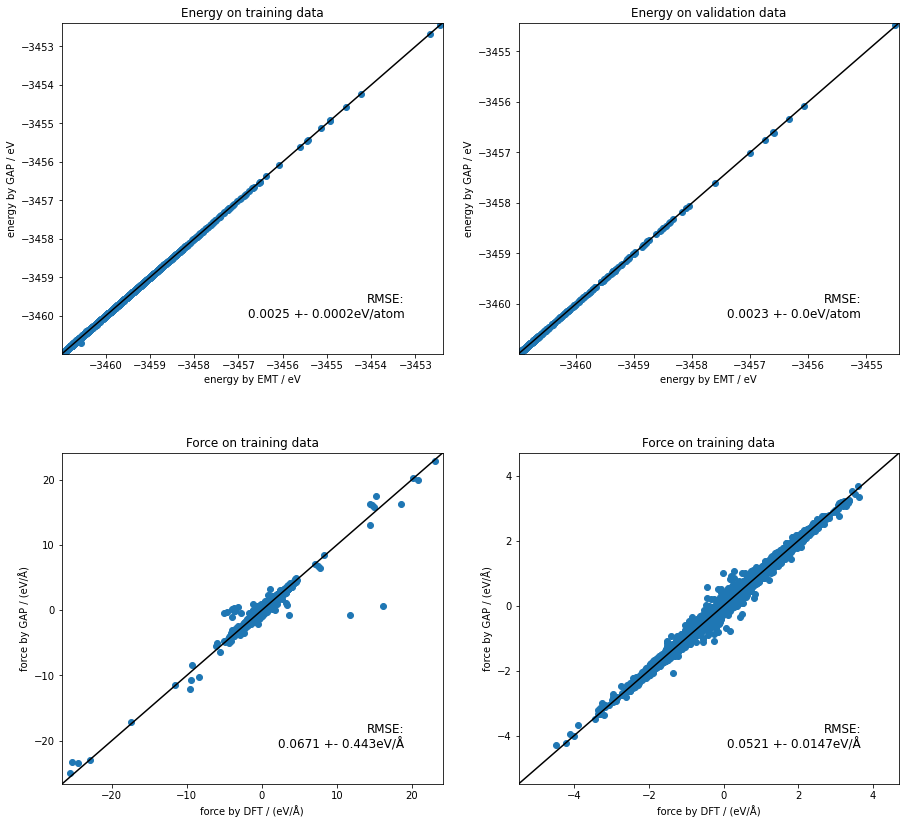

In [5]:
# An example of error analysis
# Plot the energy and force error distribution

folder = './L8_N8'

DBExtxyz_novirial(folder+'/training.xyz', folder+'/training_DFT.xyz')
DBExtxyz_novirial(folder+'/testing.xyz', folder+'/testing_DFT.xyz')
GAPExtxyz_novirial(folder+'/quip_train.xyz', folder+'/training_GAP.xyz')
GAPExtxyz_novirial(folder+'/quip_test.xyz', folder+'/testing_GAP.xyz')

fig, ax_list = plt.subplots(nrows=2, ncols=2, gridspec_kw={'hspace': 0.3})
fig.set_size_inches(15, 14)
ax_list = ax_list.flat[:]

energy_plot(folder+'/training_DFT.xyz', folder+'/training_GAP.xyz', ax_list[0], 'Energy on training data')
energy_plot(folder+'/testing_DFT.xyz', folder+'/testing_GAP.xyz', ax_list[1], 'Energy on validation data')
force_plot(folder+'/training_DFT.xyz', folder+'/training_GAP.xyz', ax_list[2], 'Fe', 'Force on training data')
force_plot(folder+'/testing_DFT.xyz', folder+'/testing_GAP.xyz', ax_list[3], 'Fe', 'Force on training data')